In [1]:
from PIL import Image, ImageOps, ImageEnhance, ImageFilter, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
import lg17cam

___
# **Image processing for sediment transport (2/3)**

### Output :: Where do we want the results of the batch of photos?

In [2]:
result_folders = {'PATH_FOLDER_TROUGHS' : r"Troughs/",
                  'PATH_FOLDER_PEAKS'   : r"Peaks/", 
                  'PATH_FOLDER_ENDIMG'  : r"Pictures/"}

## Make sure there is nothing on those foldes
for folder in result_folders.values():
    try: 
        shutil.rmtree(folder); os.mkdir(folder)
    except FileNotFoundError:
        os.mkdir(folder)

### Input :: Point the folders with all the pictures!

In [3]:
LEFT_FOLDER  = r'/home/edsaa/Documents/ClearWaterFrontlight/SmolLeft/'
RIGHT_FOLDER = r'/home/edsaa/Documents/ClearWaterFrontlight/SmolRight/'

if len(os.listdir(LEFT_FOLDER)) != len(os.listdir(RIGHT_FOLDER)):
    print("Not the same number of pics on the folders!!")

## Photographs metadata

a.k.a. EXIF information

In [4]:
from PIL.ExifTags import TAGS
from random import choice

## Pick a random image 
path = os.path.join(LEFT_FOLDER,choice(os.listdir(LEFT_FOLDER)))
img = Image.open(path)
exifdata = img.getexif()

print(f"IMAGE :: {path}\n")
for tag_id in exifdata:
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    if isinstance(data, bytes): data = data.decode()
    print(f"({tag_id:6}) {tag:25}: {data}")

IMAGE :: /home/edsaa/Documents/ClearWaterFrontlight/SmolLeft/DSC_0929.JPG

( 34853) GPSInfo                  : 15236
(   296) ResolutionUnit           : 2
( 34665) ExifOffset               : 228
(   271) Make                     : NIKON CORPORATION
(   272) Model                    : NIKON D5300
(   305) Software                 : Ver.1.03 
(   274) Orientation              : 1
(   306) DateTime                 : 2021:10:02 20:01:32
(   531) YCbCrPositioning         : 1
(   282) XResolution              : 300.0
(   283) YResolution              : 300.0


## Create a pictures batabase

We will use the DateTime field from the metadata to make sure they are sorted. 

<AxesSubplot:>

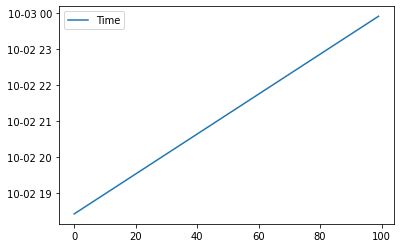

In [5]:
# Organize lefts
leftPhotos = lg17cam.getDatabasePics(LEFT_FOLDER)
leftPhotos.plot()

<AxesSubplot:>

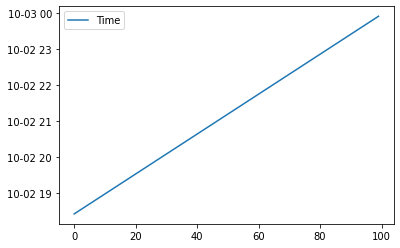

In [6]:
rightPhotos = lg17cam.getDatabasePics(RIGHT_FOLDER)
rightPhotos.plot()

In [7]:
## Create a list of filepath pairs
Paths = [(os.path.join(LEFT_FOLDER,l),os.path.join(RIGHT_FOLDER+r))
         for l,r in zip(leftPhotos['File'],rightPhotos['File'])]

____
## Analyze all picture pairs

We could use a `for` loop to analyze each pair of pictures but that will be slow. 

But we'll run these tasks in parallel with ```concurrent```, that way we avoid running them sequentally! 

In [8]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

## How many threads to use??
N_PROCS = 24

## Run with multithreading 
with ThreadPoolExecutor(max_workers=N_PROCS) as executor:          
    future = {executor.submit(lg17cam.processPair, l, r,result_folders): i for i,(l,r) in enumerate(Paths)}
        
    for f in concurrent.futures.as_completed(future):
        f.result()

In [9]:
## Get results in single file of Troughs and Peaks
PATH_TO_TROUGHS = r"allTroughs.csv"
PATH_TO_PEAKS   = r"allPeaks.csv"

for k,fout in zip(['PATH_FOLDER_TROUGHS','PATH_FOLDER_PEAKS'],[PATH_TO_TROUGHS,PATH_TO_PEAKS]):
    files = os.listdir(result_folders[k])
    files.sort()
    paths = [os.path.join(result_folders[k],f) for f in files]
    lg17cam.catFolder(paths,fout)

## Create a movie

```
cat *.JPG | ffmpeg -f image2pipe -r $FRAMERATE -vcodec mjpeg -i - -vcodec libx264 out.mp4
```